In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [3]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

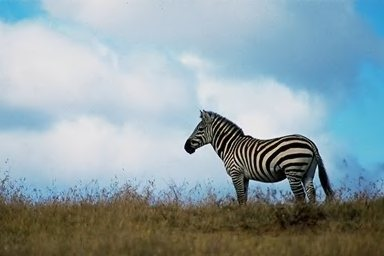

In [5]:
real_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

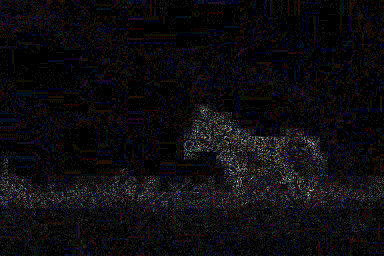

In [6]:
convert_to_ela_image(real_image_path, 90)

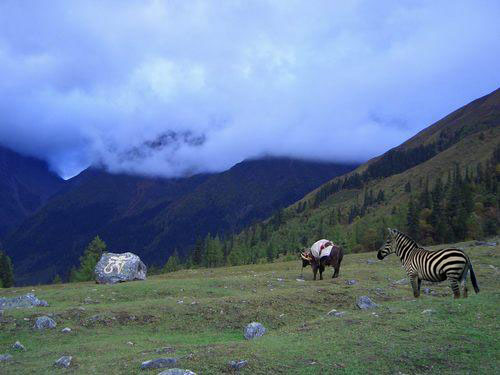

In [7]:
fake_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

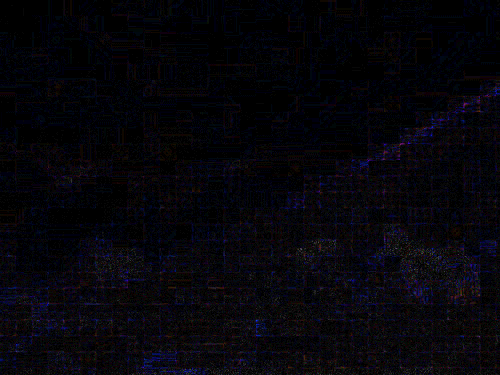

In [8]:
convert_to_ela_image(fake_image_path, 90)

In [9]:
image_size = (128, 128)

In [10]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [11]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [12]:
import random
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [13]:
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [14]:
import tensorflow as tf
X = np.array(X)
Y = tf.keras.utils.to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [19]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model
    
    

In [20]:
model = build_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import tensorflow as tf

# Define parameters
epochs = 30
batch_size = 32
init_lr = 1e-4

# Use the updated Adam optimizer (without legacy)
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr, decay=init_lr / epochs)


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [25]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'max')

In [26]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8743 - loss: 0.3485 - val_accuracy: 0.8956 - val_loss: 0.3075
Epoch 2/30
  5/105 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9348 - loss: 0.2303

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9100 - loss: 0.2733 - val_accuracy: 0.9064 - val_loss: 0.2822
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9001 - loss: 0.2739 - val_accuracy: 0.9040 - val_loss: 0.2658
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9218 - loss: 0.2239 - val_accuracy: 0.9040 - val_loss: 0.2577
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9135 - loss: 0.2286 - val_accuracy: 0.9148 - val_loss: 0.2440
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9314 - loss: 0.1901 - val_accuracy: 0.9172 - val_loss: 0.2372
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9306 - loss: 0.1822 - val_accuracy: 0.9136 - val_loss: 0.2385
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9292 - loss: 0.1925 - val_accuracy: 0.9160 - val_loss: 0.2276
Epoch 9/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9462 - loss: 0.1563 - val_accuracy: 0.922

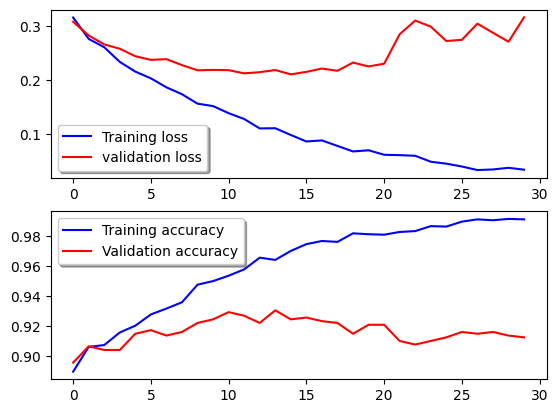

In [27]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [32]:
# Make predictions
predicted_classes = model.predict(X_val)
predicted_classes = np.argmax(predicted_classes, axis=1)

# Convert the one-hot encoded labels back to class labels
true_classes = np.argmax(Y_val, axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [33]:
# Define class labels
class_labels = ['Fake', 'Real']

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


              precision    recall  f1-score   support

        Fake       0.91      0.91      0.91       407
        Real       0.91      0.92      0.91       426

    accuracy                           0.91       833
   macro avg       0.91      0.91      0.91       833
weighted avg       0.91      0.91      0.91       833



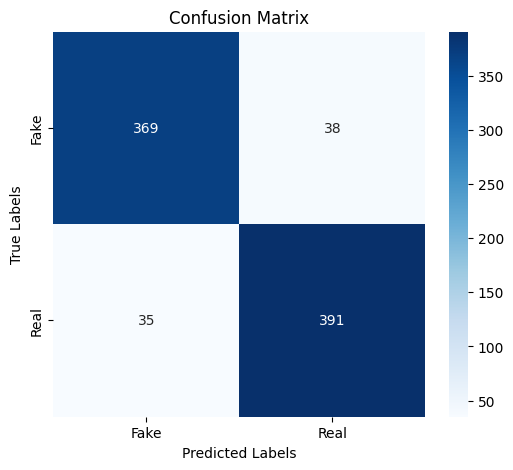

In [34]:
# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [36]:
model.save('image_forgery_detection_casia2.h5')

In [20]:
from IPython.display import FileLink
FileLink(r'image_forgery_detection_casia2.h5')

/kaggle/working/image_forgery_detection_casia2.h5